# Step 1. Initialize environment

In [1]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


# Step 2. Import codes for training

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, fc_units=[256,128,64]):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
        """
        super(QNetwork, self).__init__()
        self.fc1=nn.Linear(state_size,fc_units[0])
        self.fc2=nn.Linear(fc_units[0],fc_units[1])
        self.fc3=nn.Linear(fc_units[1],fc_units[2])
        self.fc4=nn.Linear(fc_units[2],action_size)
        self.prob = nn.LogSoftmax(dim=1)

    def forward(self, state, alpha):
        """Build a network that maps state -> action values, probabilities and state values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        log_probs = self.prob(x/alpha)
        Z = x/alpha + log_probs
        maximum = Z.max(dim=1, keepdim=True)[0]
        V = alpha*(maximum + (Z-maximum).exp().sum(dim=1, keepdim=True).log())
        return x, log_probs, V

In [8]:
import numpy as np
import random
from collections import namedtuple, deque

import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 1e-4               # learning rate 
ALPHA = 1               # Bonus for entropy reward

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, alpha=ALPHA, learning_rate=LR, gamma=GAMMA, tau=TAU):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
            lr (float): learning rate for local network
            tau (float): learning rate for target network
            gamma (float): decay rate for future rewards
            prioritized (bollean): decide whether to use prioritized Q-Learning
        """
        self.state_size = state_size
        self.action_size = action_size
        self.lr = learning_rate
        self.tau = tau
        self.gamma = gamma
        self.alpha = alpha
        
        # Replay memory
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE)
        
        # Networks
        self.qnetwork_local = QNetwork(state_size, action_size)
        self.qnetwork_target = QNetwork(state_size, action_size)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=self.lr)
        self.soft_update(self.qnetwork_local, self.qnetwork_target, 1)

    def act(self, state):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
        """
        state = torch.tensor(state, dtype=torch.float32).to(device).view(1,-1)
        _, log_probs, _ = self.qnetwork_local(state, self.alpha)
        log_probs = log_probs.detach().view(-1).numpy()
        action = np.random.choice(self.action_size, size=1, replace=False, p=np.exp(log_probs))
        return action

    def learn(self, experiences):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
        """
        states, actions, rewards, next_states, dones= experiences
        
        Q_local, _, _ = self.qnetwork_local(states, self.alpha)
        Q_local = Q_local.gather(1, actions)
        _, _, V_target = self.qnetwork_target(next_states, self.alpha)
        Q_target = rewards + (1-dones)*self.gamma*V_target.detach()
        loss = 0.5*(Q_local - Q_target).pow(2).mean()
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.qnetwork_local.parameters(), 5)
        self.optimizer.step()
        
        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, self.tau)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size):
        """Initialize a ReplayBuffer object.

        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory.
        
        Params
        ======
            priority: a vector records the priority for each experience
            alpha: to determine how much the priority should influence the probability. 
                p(sample i) ~ priority(sample i)**alpha
        """
        experiences = random.sample(self.memory, k=self.batch_size)
        
        #Extract information from memory unit and return
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [9]:
from collections import deque

def Discrete_SQN(n_episodes, max_t, agent, UPDATE):
    """
    Monitor the training process
    Params
    ======
        env, brain_name and agent are assumed to be defined elsewhere
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        finish (boolean): if True, the function finish n_episodes and return a smooth
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    means=[]
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.memory.add(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if t % UPDATE == 0:
                if len(agent.memory) > BATCH_SIZE:
                    experience = agent.memory.sample()
                    agent.learn(experience)
            if done:
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        
        print('\rEpisode {}\tEpisodic Score: {:.2f}\tAverage Score: {:.2f}'.format(i_episode, score, np.mean(scores_window),), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tEpisodic Score: {:.2f}\tAverage Score: {:.2f}'.format(i_episode, score, np.mean(scores_window)))
        means.append(np.mean(scores_window))
        
    torch.save(agent.qnetwork_local.state_dict(), 'SQN_checkpoint.pth')
    return scores, means

# Step 3. Train the agent and see the result

## $\alpha=0.01$

In [10]:
agent = Agent(state_size, action_size, alpha=0.01)
scores, means = Discrete_SQN(n_episodes=1000, max_t=1000, agent=agent, UPDATE=4)

Episode 100	Episodic Score: 0.00	Average Score: -0.03
Episode 200	Episodic Score: 4.00	Average Score: 1.495
Episode 300	Episodic Score: 0.00	Average Score: 5.850
Episode 400	Episodic Score: 18.00	Average Score: 7.87
Episode 500	Episodic Score: 9.00	Average Score: 11.665
Episode 600	Episodic Score: 18.00	Average Score: 14.56
Episode 700	Episodic Score: 17.00	Average Score: 15.81
Episode 800	Episodic Score: 17.00	Average Score: 16.55
Episode 900	Episodic Score: 20.00	Average Score: 17.36
Episode 1000	Episodic Score: 13.00	Average Score: 17.79


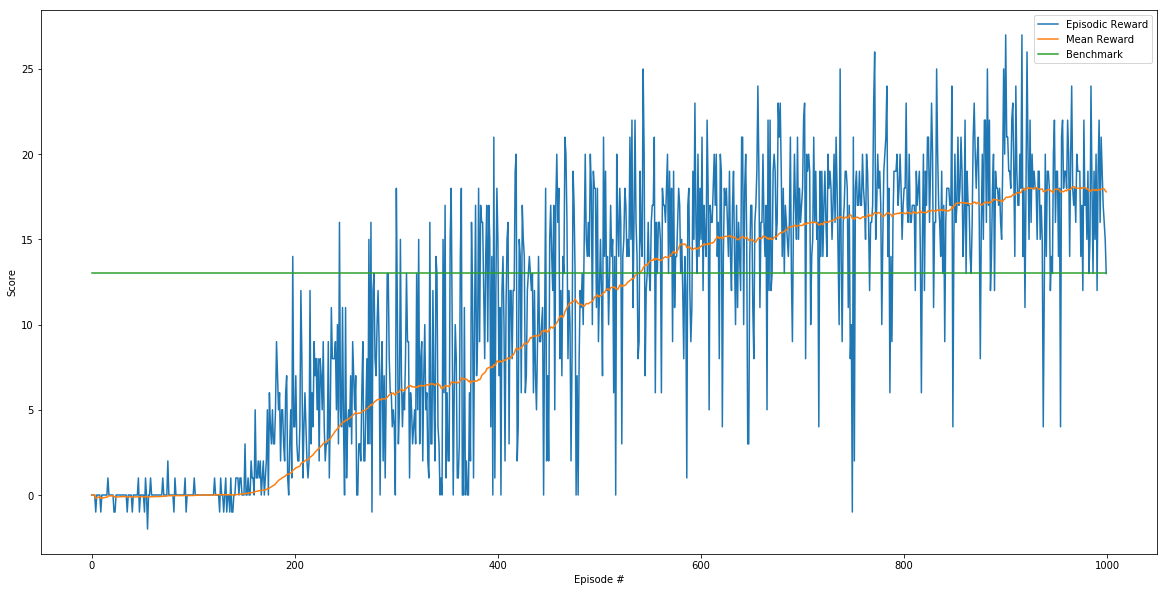

In [13]:
# plot the scores
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(np.arange(len(scores)), scores, label='Episodic Reward')
plt.plot(np.arange(len(means)), means, label='Mean Reward')
plt.plot(np.arange(len(means)), 13*np.ones(len(means)), label='Benchmark')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc=1)
plt.show()

## $\alpha=0.02$

In [18]:
agent = Agent(state_size, action_size, alpha=0.02)
scores, means = Discrete_SQN(n_episodes=1000, max_t=1000, agent=agent, UPDATE=4)

Episode 100	Episodic Score: 1.00	Average Score: 2.229
Episode 200	Episodic Score: 12.00	Average Score: 6.92
Episode 300	Episodic Score: 4.00	Average Score: 11.119
Episode 400	Episodic Score: 16.00	Average Score: 14.13
Episode 500	Episodic Score: 13.00	Average Score: 16.42
Episode 600	Episodic Score: 12.00	Average Score: 16.39
Episode 700	Episodic Score: 12.00	Average Score: 15.78
Episode 800	Episodic Score: 20.00	Average Score: 16.48
Episode 900	Episodic Score: 22.00	Average Score: 15.72
Episode 1000	Episodic Score: 22.00	Average Score: 16.09


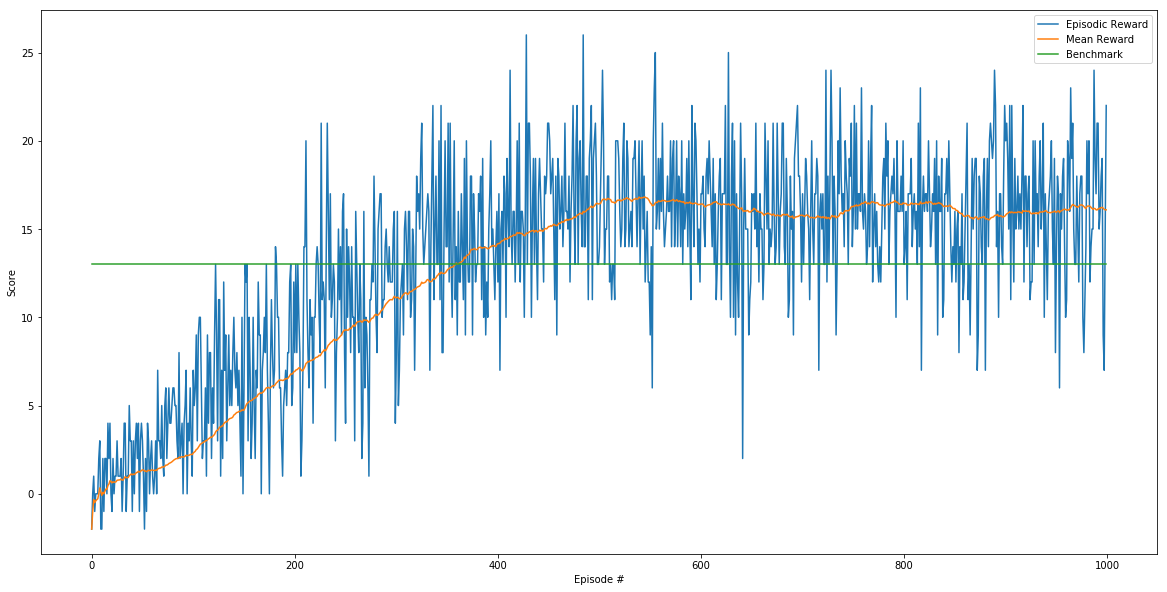

In [19]:
plt.figure(figsize=(20,10))
plt.plot(np.arange(len(scores)), scores, label='Episodic Reward')
plt.plot(np.arange(len(means)), means, label='Mean Reward')
plt.plot(np.arange(len(means)), 13*np.ones(len(means)), label='Benchmark')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc=1)
plt.show()

## $\alpha=0.05$

In [16]:
agent = Agent(state_size, action_size, alpha=0.05)
scores, means = Discrete_SQN(n_episodes=1000, max_t=1000, agent=agent, UPDATE=4)

Episode 100	Episodic Score: 13.00	Average Score: 4.45
Episode 200	Episodic Score: 8.00	Average Score: 7.326
Episode 300	Episodic Score: 15.00	Average Score: 10.53
Episode 400	Episodic Score: 18.00	Average Score: 12.37
Episode 500	Episodic Score: 16.00	Average Score: 12.61
Episode 600	Episodic Score: 11.00	Average Score: 12.53
Episode 700	Episodic Score: 12.00	Average Score: 12.18
Episode 800	Episodic Score: 10.00	Average Score: 13.01
Episode 900	Episodic Score: 14.00	Average Score: 13.66
Episode 1000	Episodic Score: 5.00	Average Score: 13.49


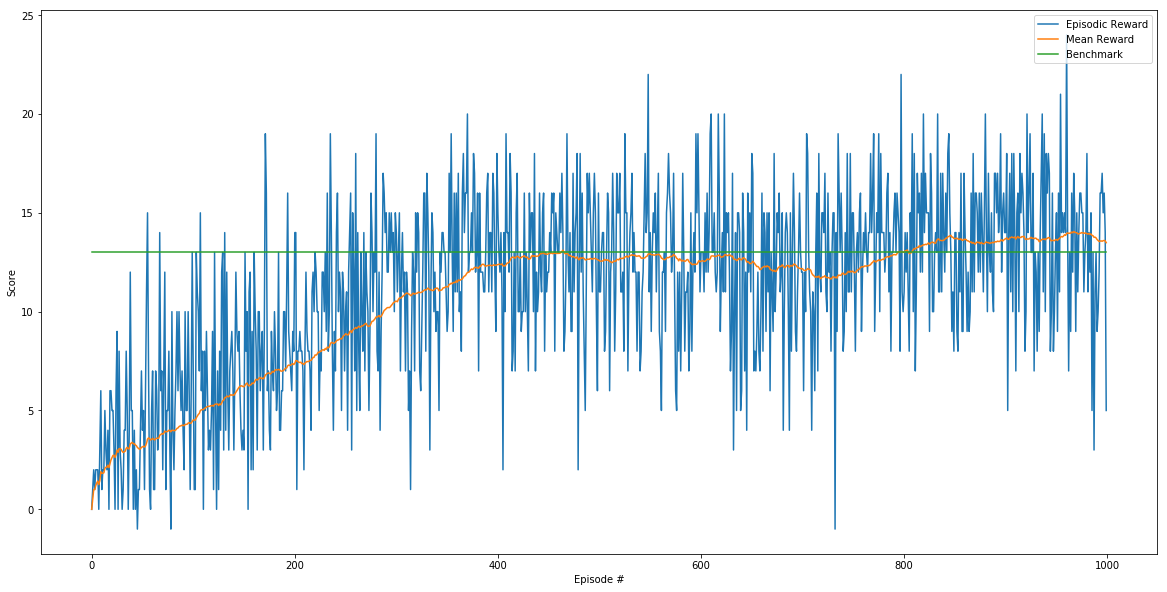

In [17]:
plt.figure(figsize=(20,10))
plt.plot(np.arange(len(scores)), scores, label='Episodic Reward')
plt.plot(np.arange(len(means)), means, label='Mean Reward')
plt.plot(np.arange(len(means)), 13*np.ones(len(means)), label='Benchmark')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc=1)
plt.show()

## $\alpha=0.1$

In [14]:
agent = Agent(state_size, action_size, alpha=0.1)
scores, means = Discrete_SQN(n_episodes=1000, max_t=1000, agent=agent, UPDATE=4)

Episode 100	Episodic Score: 1.00	Average Score: 0.81
Episode 200	Episodic Score: -1.00	Average Score: 2.35
Episode 300	Episodic Score: 9.00	Average Score: 5.289
Episode 400	Episodic Score: 5.00	Average Score: 5.863
Episode 500	Episodic Score: 4.00	Average Score: 6.122
Episode 600	Episodic Score: 6.00	Average Score: 6.082
Episode 700	Episodic Score: 8.00	Average Score: 6.152
Episode 800	Episodic Score: 2.00	Average Score: 5.665
Episode 900	Episodic Score: 4.00	Average Score: 5.919
Episode 1000	Episodic Score: 5.00	Average Score: 5.71


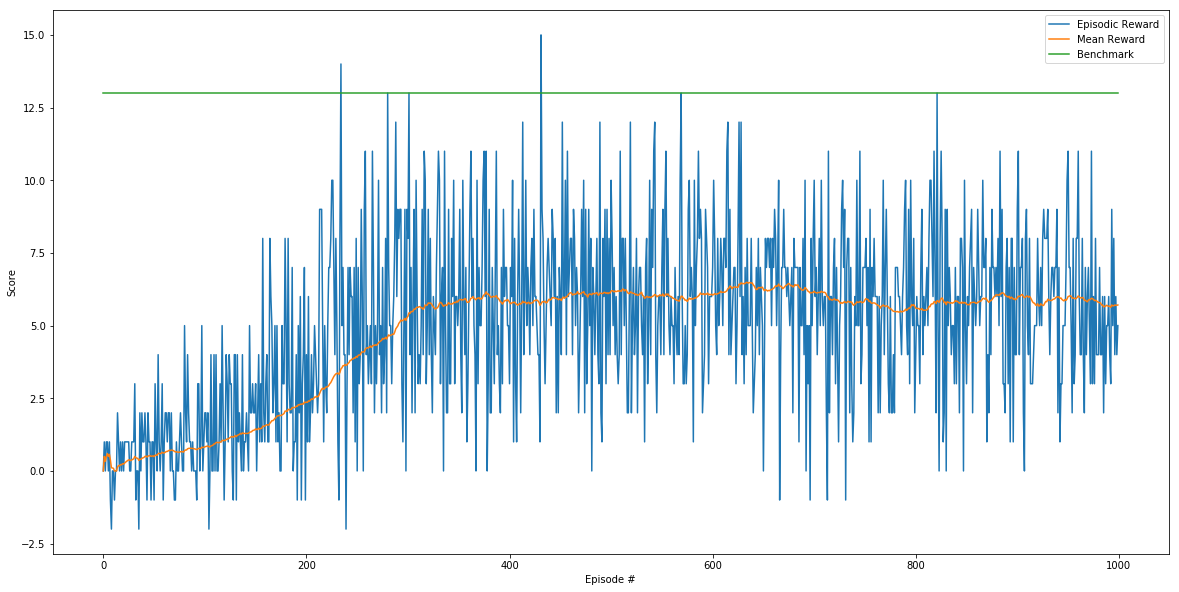

In [15]:
plt.figure(figsize=(20,10))
plt.plot(np.arange(len(scores)), scores, label='Episodic Reward')
plt.plot(np.arange(len(means)), means, label='Mean Reward')
plt.plot(np.arange(len(means)), 13*np.ones(len(means)), label='Benchmark')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc=1)
plt.show()

In [20]:
env.close()